In [124]:
# Load libs (plus additional for next rounds)
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from xgboost import cv
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [85]:
# loading the train dataset and checking the info
df=pd.read_csv('train_age.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [86]:
# retrieving cols order to check later with the test data
cols_df=df.columns[df.columns!='Class']
cols_df

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL'],
      dtype='object')

In [87]:
# coding categorical column
df.EJ.replace(to_replace=['A','B'],value=[0,1], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [88]:
round(df.isna().sum()/len(df)*100,2)

Id       0.00
AB       0.00
AF       0.00
AH       0.00
AM       0.00
AR       0.00
AX       0.00
AY       0.00
AZ       0.00
BC       0.00
BD       0.00
BN       0.00
BP       0.00
BQ       9.72
BR       0.00
BZ       0.00
CB       0.32
CC       0.49
CD       0.00
CF       0.00
CH       0.00
CL       0.00
CR       0.00
CS       0.00
CU       0.00
CW       0.00
DA       0.00
DE       0.00
DF       0.00
DH       0.00
DI       0.00
DL       0.00
DN       0.00
DU       0.16
DV       0.00
DY       0.00
EB       0.00
EE       0.00
EG       0.00
EH       0.00
EJ       0.00
EL       9.72
EP       0.00
EU       0.00
FC       0.16
FD       0.00
FE       0.00
FI       0.00
FL       0.16
FR       0.00
FS       0.32
GB       0.00
GE       0.00
GF       0.00
GH       0.00
GI       0.00
GL       0.16
Class    0.00
dtype: float64

In [89]:
# replacing nans for the columns with nans by the medians
imputer = SimpleImputer(missing_values = np.nan,
                        strategy ='median')
imputer = imputer.fit(df.loc[:,~df.columns.isin(['Id','Class'])])
df.loc[:,~df.columns.isin(['Id','Class'])] = imputer.transform(df.loc[:,~df.columns.isin(['Id','Class'])])
round(df.isna().sum()/len(df)*100,2)

Id       0.0
AB       0.0
AF       0.0
AH       0.0
AM       0.0
AR       0.0
AX       0.0
AY       0.0
AZ       0.0
BC       0.0
BD       0.0
BN       0.0
BP       0.0
BQ       0.0
BR       0.0
BZ       0.0
CB       0.0
CC       0.0
CD       0.0
CF       0.0
CH       0.0
CL       0.0
CR       0.0
CS       0.0
CU       0.0
CW       0.0
DA       0.0
DE       0.0
DF       0.0
DH       0.0
DI       0.0
DL       0.0
DN       0.0
DU       0.0
DV       0.0
DY       0.0
EB       0.0
EE       0.0
EG       0.0
EH       0.0
EJ       0.0
EL       0.0
EP       0.0
EU       0.0
FC       0.0
FD       0.0
FE       0.0
FI       0.0
FL       0.0
FR       0.0
FS       0.0
GB       0.0
GE       0.0
GF       0.0
GH       0.0
GI       0.0
GL       0.0
Class    0.0
dtype: float64

In [90]:
# checking the datatypes and nans
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      617 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      617 non-null    float64
 17  CC      617 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [91]:
# we deal with a classification problem
df.Class.value_counts()

0    509
1    108
Name: Class, dtype: int64

In [92]:
# implementing automatic Anova approach for treatment of the categorical columns
# defining a function to get the p_value
import scipy.stats as stats
def p_test_cat(dataframe,col_x,col_y):
    cols=list(dataframe[col_x].value_counts().index) 
    results=[]
    for i in cols:
        i=dataframe[dataframe[col_x]==i][[col_y]]
        results.append(i)
    statistics, p_value=stats.f_oneway(*results)
    return p_value

In [93]:
# selecting the columns for further test
cols_to_test=df.columns[~df.columns.isin(['ID','Class'])]
cols_to_test

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL'],
      dtype='object')

In [94]:
# selecting the columns to delete (with p_value > 0.05)
cols_to_drop=[]
for i in cols_to_test:
    if p_test_cat(df,i,'Class')>0.05:
        cols_to_drop.append(i)
cols_to_drop

['AH',
 'AM',
 'AY',
 'AZ',
 'BN',
 'BR',
 'CB',
 'CC',
 'CD ',
 'CH',
 'CR',
 'CS',
 'CU',
 'CW ',
 'DH',
 'DL',
 'EE',
 'EG',
 'EL',
 'EP',
 'FC',
 'FR',
 'FS',
 'GB',
 'GE',
 'GF',
 'GH',
 'GI']

In [95]:
# dropping the columns after p-test
df=df.drop(cols_to_drop,axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AR      617 non-null    float64
 4   AX      617 non-null    float64
 5   BC      617 non-null    float64
 6   BD      617 non-null    float64
 7   BP      617 non-null    float64
 8   BQ      617 non-null    float64
 9   BZ      617 non-null    float64
 10  CF      617 non-null    float64
 11  CL      617 non-null    float64
 12  DA      617 non-null    float64
 13  DE      617 non-null    float64
 14  DF      617 non-null    float64
 15  DI      617 non-null    float64
 16  DN      617 non-null    float64
 17  DU      617 non-null    float64
 18  DV      617 non-null    float64
 19  DY      617 non-null    float64
 20  EB      617 non-null    float64
 21  EH      617 non-null    float64
 22  EJ

In [96]:
# before embarking on the modelling, I implement perturbation of the dataset
dfr=pd.DataFrame(np.random.permutation(df.values),columns=df.columns)

In [97]:
# rearranging the dataframe
id=dfr.Id
dfr=dfr.drop('Id',axis=1)

In [98]:
# defining X and y
X=dfr.drop("Class",axis=1)
Y=dfr[["Class"]]

In [99]:
# Outliers removal
lof = LocalOutlierFactor()
yhat = lof.fit_predict(X)
mask = yhat != -1
x,y=X.loc[mask,:],Y.loc[mask,:]

In [109]:
# splitting data into train and test 
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 1)

In [101]:
# scaling data for x, train and test (keeping logics of fitting and transforming)
scaler=StandardScaler()
x_all=scaler.fit(x)
xx=x_all.transform(x)
X_tr=scaler.fit(X_train)
X_train_sc=X_tr.transform(X_train)
X_test_sc=X_tr.transform(X_test)

In [102]:
# changing datatype of y
y['Class']=y['Class'].astype(bool)
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 582 entries, 0 to 616
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Class   582 non-null    bool 
dtypes: bool(1)
memory usage: 5.1 KB


In [103]:
# checking the results for y
y.value_counts()

Class
False    491
True      91
dtype: int64

In [104]:
# since we work with the classification problem, the classifiers were selected for modelling
# set of different models to choose the best ones for further experiments
# for the final set I'll choose GBC and XGB
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RandFC', RandomForestClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('XGB', xgb.XGBClassifier()))

results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, xx, np.ravel(y), cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %.2f (%.2f)' % (name, cv_results.mean(), cv_results.std()))


LR: 0.89 (0.02)
LDA: 0.89 (0.01)
KNN: 0.88 (0.01)
NB: 0.86 (0.02)
SVM: 0.88 (0.01)
CART: 0.85 (0.02)
RandFC: 0.91 (0.02)
GBC: 0.91 (0.01)
XGB: 0.91 (0.02)


In [105]:
# further I'll do HP tuning for the three best models (RFC, GBC, XGB)
# RandomForest HPs tuning
from scipy.stats import loguniform
n_estimators = [5,20,50,100,150,200,300] # number of trees in the random forest
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
max_leaf_nodes=[2, 5, 10, 20, 50, 100]
max_features=['sqrt', 'log2', None]

rfc_param_grid = {'n_estimators': n_estimators,
'max_depth': max_depth,
'max_leaf_nodes':max_leaf_nodes,
'max_features':max_features}

print ('RFC_param_grid: ', rfc_param_grid, '\n')

RFC_param_grid:  {'n_estimators': [5, 20, 50, 100, 150, 200, 300], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'max_leaf_nodes': [2, 5, 10, 20, 50, 100], 'max_features': ['sqrt', 'log2', None]} 



In [106]:
# initializing the model and running RF
rfc=RandomForestClassifier()
# rfc_random = GridSearchCV(estimator = rfc,param_grid = rfc_param_grid,
#                cv = 3, verbose=2, n_jobs = -1, scoring="neg_log_loss")
rfc_random = RandomizedSearchCV(estimator = rfc,param_distributions = rfc_param_grid,
               n_iter = 100, cv = 3, verbose=2, random_state=1, n_jobs = -1, scoring="neg_log_loss")
rfc_random.fit(x,np.ravel(y))
print("Best parameters found: ", rfc_random.best_params_)
print("Best score: ", -rfc_random.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found:  {'n_estimators': 200, 'max_leaf_nodes': 50, 'max_features': 'sqrt', 'max_depth': 30}
Best score:  0.24189845746287772


In [111]:
# fitting the model with the optimal parameters
rfc_opt_params=rfc_random.best_params_
rfc_opt = RandomForestClassifier(**rfc_opt_params)
rfc_opt.fit(X_train,np.ravel(y_train))

RandomForestClassifier(max_depth=30, max_leaf_nodes=50, n_estimators=200)

In [112]:
# GradientBoosting HPs tuning
n_estimators = [5,20,50,100,150,200,300] # number of trees in the random forest
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
max_leaf_nodes=[2, 5, 10, 20, 50, 100]

random_grid = {'n_estimators': n_estimators,
'max_depth': max_depth,
'max_leaf_nodes':max_leaf_nodes,
'learning_rate': loguniform(0.01, 1)}

print ('Random grid: ', random_grid, '\n')

Random grid:  {'n_estimators': [5, 20, 50, 100, 150, 200, 300], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'max_leaf_nodes': [2, 5, 10, 20, 50, 100], 'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000025AC8903B80>} 



In [113]:
# initializing the model and running the GB
gbr=GradientBoostingClassifier(loss='log_loss')
# gbr_random=GridSearchCV(estimator = gbr,param_grid = random_grid,
#                cv = 3, verbose=2, n_jobs = -1, scoring="neg_log_loss")
gbr_random = RandomizedSearchCV(estimator = gbr,param_distributions = random_grid,
               n_iter = 100, cv = 3, verbose=2, random_state=1, n_jobs = -1, scoring="neg_log_loss")
gbr_random.fit(x,np.ravel(y))
print("Best parameters found: ", gbr_random.best_params_)
print("Best score: ", -gbr_random.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found:  {'learning_rate': 0.07141996801463805, 'max_depth': 70, 'max_leaf_nodes': 2, 'n_estimators': 200}
Best score:  0.2605711586673371


In [114]:
# fitting the model with the optimal parameters
gbr_opt_params=gbr_random.best_params_
gbr_opt = GradientBoostingClassifier(**gbr_opt_params,loss='log_loss')
gbr_opt.fit(X_train,np.ravel(y_train))

GradientBoostingClassifier(learning_rate=0.07141996801463805, max_depth=70,
                           max_leaf_nodes=2, n_estimators=200)

In [115]:
# # initializing the model and running XGB HPs tuning
xgbc = xgb.XGBClassifier()
xgb_random_grid = {
    'colsample_bytree': [0.3, 0.7, 1.0],
    'n_estimators': [150,200,250,300],
    'max_depth': range(2, 11)}
# xgb_random=GridSearchCV(estimator = xgbc,param_grid = xgb_random_grid,
#                cv = 3, verbose=2, n_jobs = -1, scoring="neg_log_loss")
xgb_random = RandomizedSearchCV(estimator = xgbc,param_distributions = xgb_random_grid,
               n_iter = 100, cv = 3, verbose=2, random_state=1, n_jobs = -1, scoring="neg_log_loss")
xgb_random.fit(xx,np.ravel(y))
print("Best parameters found: ", xgb_random.best_params_)
print("Best score: ", -xgb_random.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found:  {'n_estimators': 150, 'max_depth': 3, 'colsample_bytree': 0.3}
Best score:  0.2627374736908015


In [116]:
# fitting the model with the optimal parameters
xgb_params=xgb_random.best_params_
xgb_opt=xgb.XGBClassifier(**xgb_params)
xgb_opt.fit(X_train_sc, np.ravel(y_train))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [117]:
# and finally I'll experiment with Tensorflow model
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

In [118]:
# changing y datatype for categorical
y_train_cat=to_categorical(y_train)
y_test_cat=to_categorical(y_test)

In [119]:
# xx_cast=tf.cast(xx, tf.float32)
X_train_sc_cast=tf.cast(X_train_sc, tf.float32)
X_test_sc_cast=tf.cast(X_test_sc, tf.float32)

In [120]:
# setting up the functional model and early stopping monitor
input = tf.keras.layers.Input(shape = X_train_sc_cast.shape[1:])
hidden1 = tf.keras.layers.Dense(150, activation='relu')(input)
hidden2 = tf.keras.layers.Dense(150, activation='relu')(hidden1)
hidden3 = tf.keras.layers.Dense(150, activation='relu')(hidden2)
concat = tf.keras.layers.Concatenate()([input, hidden3])
output = tf.keras.layers.Dense(2,activation='softmax')(concat)
model_funct = tf.keras.models.Model(inputs=[input], outputs=[output])

model_funct.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

early_stopping=EarlyStopping(patience=100)

model_tf=model_funct.fit(X_train_sc_cast, y_train_cat, epochs=500, validation_data=(X_test_sc_cast,y_test_cat), callbacks=[early_stopping])

Epoch 1/500
15/15 [==============================] - 1s 12ms/step - loss: 0.4603 - accuracy: 0.8194 - val_loss: 0.3442 - val_accuracy: 0.8974
Epoch 2/500
15/15 [==============================] - 0s 3ms/step - loss: 0.2799 - accuracy: 0.8989 - val_loss: 0.2552 - val_accuracy: 0.9231
Epoch 3/500
15/15 [==============================] - 0s 3ms/step - loss: 0.2122 - accuracy: 0.9161 - val_loss: 0.2298 - val_accuracy: 0.9231
Epoch 4/500
15/15 [==============================] - 0s 3ms/step - loss: 0.1638 - accuracy: 0.9441 - val_loss: 0.2181 - val_accuracy: 0.9060
Epoch 5/500
15/15 [==============================] - 0s 3ms/step - loss: 0.1360 - accuracy: 0.9613 - val_loss: 0.2564 - val_accuracy: 0.9402
Epoch 6/500
15/15 [==============================] - 0s 3ms/step - loss: 0.0976 - accuracy: 0.9613 - val_loss: 0.2435 - val_accuracy: 0.9060
Epoch 7/500
15/15 [==============================] - 0s 3ms/step - loss: 0.0728 - accuracy: 0.9828 - val_loss: 0.2412 - val_accuracy: 0.9060
Epoch 8/500


Epoch 58/500
15/15 [==============================] - 0s 3ms/step - loss: 7.6542e-05 - accuracy: 1.0000 - val_loss: 0.5374 - val_accuracy: 0.9060
Epoch 59/500
15/15 [==============================] - 0s 3ms/step - loss: 7.2841e-05 - accuracy: 1.0000 - val_loss: 0.5372 - val_accuracy: 0.9060
Epoch 60/500
15/15 [==============================] - 0s 3ms/step - loss: 6.9939e-05 - accuracy: 1.0000 - val_loss: 0.5391 - val_accuracy: 0.9060
Epoch 61/500
15/15 [==============================] - 0s 3ms/step - loss: 6.7071e-05 - accuracy: 1.0000 - val_loss: 0.5424 - val_accuracy: 0.9060
Epoch 62/500
15/15 [==============================] - 0s 3ms/step - loss: 6.4453e-05 - accuracy: 1.0000 - val_loss: 0.5443 - val_accuracy: 0.9060
Epoch 63/500
15/15 [==============================] - 0s 3ms/step - loss: 6.2022e-05 - accuracy: 1.0000 - val_loss: 0.5457 - val_accuracy: 0.9060
Epoch 64/500
15/15 [==============================] - 0s 3ms/step - loss: 5.9816e-05 - accuracy: 1.0000 - val_loss: 0.5486 -

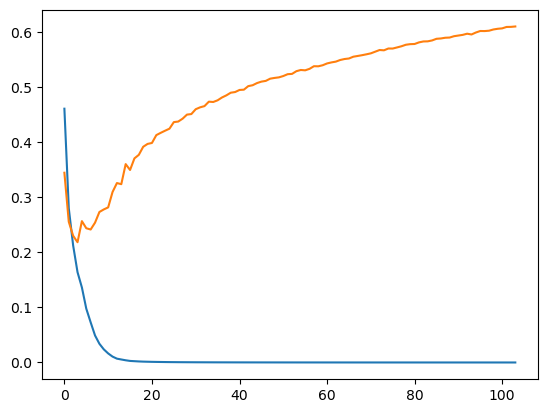

In [121]:
# plotting the history of the model
# given the goal is to minimize loss, after the 15-th epoch the loss doesn't improve
plt.plot(model_tf.history['loss'])
plt.plot(model_tf.history['val_loss'])
plt.show()

In [122]:
# ensemble of the models based on the average of the predictions of the four models
predictions_xgb=xgb_opt.predict_proba(X_test_sc)
predictions_sgbc=gbr_opt.predict_proba(X_test)
predictions_rfc=rfc_opt.predict_proba(X_test)
predictions_tf=model_funct.predict(X_test_sc_cast)
pred_ensemble=(predictions_xgb+predictions_sgbc+predictions_rfc+predictions_tf)/4
pred_ensemble_1col=np.round(pred_ensemble[:,1],0)

4/4 [==============================] - 0s 1ms/step


In [123]:
# print accuracy, confusion matrix & classification report for test data
print("accuracy_score")
print('%.2f' % accuracy_score(np.ravel(y_test), pred_ensemble_1col))
print("________________________________________________________")
print("confusion_matrix")
print(confusion_matrix(np.ravel(y_test), pred_ensemble_1col))
print("________________________________________________________")
print("classification_report")
print(classification_report(np.ravel(y_test), pred_ensemble_1col))

accuracy_score
0.93
________________________________________________________
confusion_matrix
[[98  3]
 [ 5 11]]
________________________________________________________
classification_report
              precision    recall  f1-score   support

       False       0.95      0.97      0.96       101
        True       0.79      0.69      0.73        16

    accuracy                           0.93       117
   macro avg       0.87      0.83      0.85       117
weighted avg       0.93      0.93      0.93       117

